In [1]:
# basic libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# NLP
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS 
from langdetect import detect
import spacy
from collections import Counter
import nltk
from nltk.collocations import *

In [2]:
data = {"gazeta_pl": pd.read_csv(r"C:\Users\szklarnia\Desktop\datascience\projekty\monitoring prasy\scraping_data\gazeta_pl.csv",sep="^"),
       "oko_press": pd.read_csv(r"C:\Users\szklarnia\Desktop\datascience\projekty\monitoring prasy\scraping_data\Oko_press_all.csv",sep="^"),
       "onet": pd.read_csv(r"C:\Users\szklarnia\Desktop\datascience\projekty\monitoring prasy\scraping_data\onet.csv",sep="^",error_bad_lines=False),
       "wp":pd.read_csv(r"C:\Users\szklarnia\Desktop\datascience\projekty\monitoring prasy\scraping_data\wp.csv",sep="^",error_bad_lines=False),
       "wPolityce":pd.read_csv(r"C:\Users\szklarnia\Desktop\datascience\projekty\monitoring prasy\scraping_data\wPolityce.csv",sep="^"),
       "niezalezna":pd.read_csv(r"C:\Users\szklarnia\Desktop\datascience\projekty\monitoring prasy\scraping_data\niezalezna.csv",sep="^").rename({"Content\r":"Content"},axis=1),
       "krypol":pd.read_csv(r"C:\Users\szklarnia\Desktop\datascience\projekty\monitoring prasy\scraping_data\krypol.csv",sep="^")}

b'Skipping line 1195: expected 5 fields, saw 9\n'


In [3]:
# loading spacy model
nlp = spacy.load("pl_core_news_lg")

In [32]:
type(nlp("ja")[0].lemma_)

str

In [36]:
# loading emotional dictionary
emotional_df = pd.read_csv(r"emotions.csv")

In [39]:
emotional_df = emotional_df[emotional_df.stopien_nacechowania.isin(["- m","+ m"])]

In [40]:
def count_emotional_value(text,emotional_df):
    emotional_score = 0
    values = {"- m":-4,
             "+ m":4}
    for word in text:
        try:
            value = values[emotional_df[emotional_df["lemat"] == word].iloc[0].stopien_nacechowania]
        except IndexError:
            continue
            
        emotional_score += value
            
    return emotional_score

In [41]:
def preprocess_data(data,nlp,emotional_df):
    
    # process texts
    data["processed"] = [nlp(x) for x in data.Content.astype("str")]
    print("done 1")
    data["lemmatized"] = [[x.lemma_ for x in text] for text in data.processed]
    print("done 2")
    
    
    # computing emotional values of texts
    data["emotional_value"] = [count_emotional_value(x,emotional_df) for x in data.lemmatized]
    
    
    return data

In [42]:
for key in data.keys():
    print(key)
    data[key] = preprocess_data(data[key],nlp,emotional_df)

gazeta_pl
done 1
done 2
oko_press
done 1
done 2
onet
done 1
done 2
wp
done 1
done 2
wPolityce
done 1
done 2
niezalezna
done 1
done 2
krypol
done 1
done 2


Positive 633 Negative 661


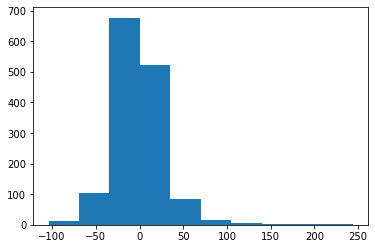

Positive 166 Negative 119


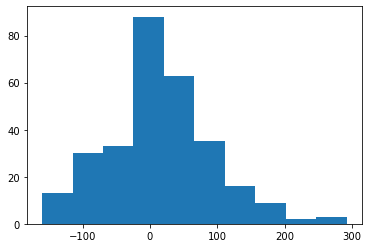

Positive 756 Negative 774


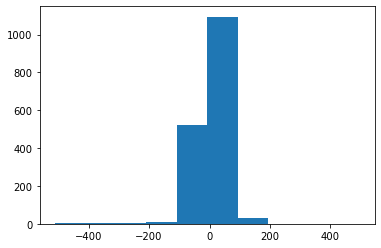

Positive 621 Negative 893


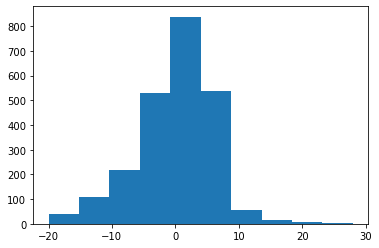

Positive 1129 Negative 841


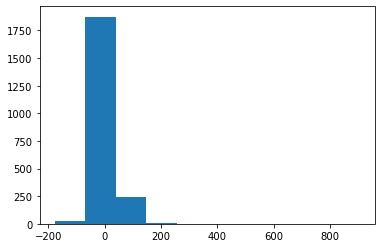

Positive 1544 Negative 1575


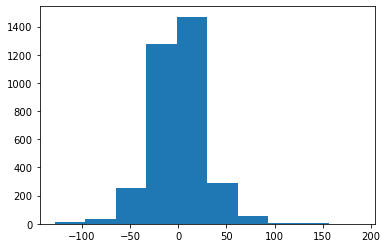

Positive 31 Negative 19


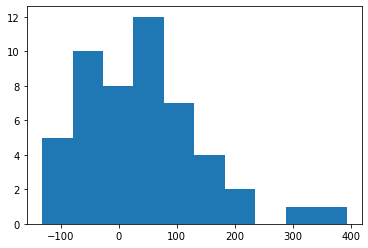

In [43]:
for key in data.keys():
    # print amounts of articles in positive and negative class
    print("Positive",data[key][data[key].emotional_value > 0].Title.count(),
          "Negative",data[key][data[key].emotional_value < 0].Title.count())
    
    # plot histogram to see the distribution of values
    plt.hist(data[key].emotional_value)
    plt.show()

In [44]:
data["gazeta_pl"].processed[0][0]

Szczepienie

We can split the articles by emotional score for positive and negative and pass preprocessed texts to a model for classification

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
# classificators
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from tensorflow.python.keras.utils import np_utils
# tensorflow and keras
import keras
from keras import regularizers, optimizers
from keras.layers.experimental.preprocessing import TextVectorization
from keras.layers import Activation, Embedding, Dense, Dropout, Input, LSTM,MaxPooling1D,Flatten,SpatialDropout1D,BatchNormalization, Conv1D
from keras.models import Sequential
from keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import History,EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import one_hot

In [46]:
# creating lerning set

learning_set = pd.DataFrame({"Emotion":[], "Text":[]})

for key in data.keys():
    # for each dataframe take emotional values and text, assign to new DF, append to learning set
    
    frame = pd.DataFrame({"Emotion":data[key].emotional_value,"Text":data[key].processed})
    learning_set = learning_set.append(frame,ignore_index=True)

In [ ]:
learning

In [52]:
learning_set["Logistic"] = [str([x.lemma_ for x in text]).replace("'","").replace(",","").replace("[","").replace("]","")\
                            for text in learning_set.Text]
learning_set["Text"] = [[str(x) for x in text] for text in learning_set["Text"]]

In [53]:
learning_set.to_csv("learning_set.csv",sep="^")

In [27]:
# drop NaNs from learning set
learning_set.dropna(inplace=True)

In [29]:
# prepare target and features variable

y = pd.Series([0 if x<0 else 1 for x in learning_set["Emotion"]])
y_log = pd.Series([0 if x<0 else 1 for x in learning_set["Emotion"]])
X_log = pd.Series(learning_set["Logistic"])
X = pd.Series(learning_set["Text"])

In [30]:
# 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train_l,X_test_l,y_train_l,y_test_l = train_test_split(X_log,y_log,test_size=0.2)

Baseline model - logistic regression

In [31]:
# fit the model on simple logistic regression to check wether the set is classifiable

mdl = make_pipeline(CountVectorizer(),LogisticRegression(solver="liblinear"))
                    
mdl.fit(X_train_l,y_train_l)
mdl.score(X_test_l,y_test_l)

0.8418502202643172

In [52]:
# prepare train and test variables for tokenizing - make sure that every element is a string

X_train_for_tokenizer = [[str(x) for x in y] for y in X_train] 
X_test_for_tokenizer = [[str(x) for x in y] for y in X_test] 



In [192]:
# median length of textsw
np.median([len(x) for x in X_train_for_tokenizer])

355.0

In [220]:
# tokenizer with custom filter - does not filter out comas, stops, ? and !, as they can carry important insights
t = Tokenizer(lower=False,filters='#$%&+-/<=>@[\\]^_`{|}~\t\n')
t.fit_on_texts(X_train_for_tokenizer)

# vocab size for embedding martix
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train_for_tokenizer)
encoded_test = t.texts_to_sequences(X_test_for_tokenizer)

# variable for storing words with no vector representation
no_vecs = []

# number of embedding dimensions for spacy vectors
embedding_dim = len(nlp('The').vector)

# creating empty embedding matrix 
embedding_matrix = np.zeros((vocab_size, embedding_dim))
# for earch word, appending embedding matrix with spacy vector
for word,i in t.word_index.items():
    embedding_matrix[i] = nlp(word).vector
    # finding empty word vectors
    if np.sum(nlp(word).vector) == 0:
        no_vecs.append(word)

# padding texts 
max_length = 1000
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

    


In [247]:
history = History()
model = Sequential()
model.add(Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length = max_length,
    trainable=True))
model.add(LSTM(100,return_sequences=True))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 300)          54412500  
_________________________________________________________________
lstm_15 (LSTM)               (None, 500, 100)          160400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 100)          400       
_________________________________________________________________
activation (Activation)      (None, 500, 100)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                30200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)               

In [258]:
Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])
save_best_model = ModelCheckpoint("sentiment.h5",save_best_only=True)

model.fit(padded_docs_half,y_train,validation_split=0.2,batch_size=8,epochs=50,callbacks=[history,save_best_model])


Epoch 1/50
400/400 [==============================] - 764s 2s/step - loss: 0.7134 - accuracy: 0.5560 - val_loss: 0.6720 - val_accuracy: 0.5975


MemoryError: 

Test 1.: Sample size: 0.05 of training set, sequence_padding- 2020  
history = History()  
model = Sequential()  
model.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=2020,trainable=False,mask_zero=True))  
model.add(LSTM(25))  
model.add(BatchNormalization())  
model.add(Dropout(0.7))  
model.add(Dense(1,activation="sigmoid"))  
model.summary()  

Good fit on test set, bad on valid. 143 epochs, loss: 0.415, acc: 0.83, val_loss: 0.9 val_acc = 0.475  

Test 2: Sample size: 0.1 of training set  

history = History()  
model = Sequential()  
model.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=1200,trainable=False,mask_zero=True))  
model.add(LSTM(100))  
model.add(BatchNormalization())  
model.add(Dropout(0.7))  
model.add(Dense(1,activation="sigmoid"))  
model.summary()  

43 epochs, loss: 0.3937 - accuracy: 0.8160 - val_loss: 0.9057 - val_accuracy: 0.4873

Test 3: 
history = History()  
model = Sequential()  
model.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=1200,trainable=False,mask_zero=True))  
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))  
model.add(MaxPooling1D(pool_size=2))  
model.add(LSTM(50))  
model.add(BatchNormalization())  
model.add(Dropout(0.5))  
model.add(Dense(1,activation="sigmoid"))  
model.summary()  

No better results achieved, stopped on 15 epoch

